# 1 Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.model_selection import train_test_split

import statsmodels
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler,LabelEncoder

from sklearn                  import metrics
from sklearn.linear_model     import LogisticRegression
from sklearn.metrics          import classification_report
from sklearn.metrics          import cohen_kappa_score
from sklearn.metrics          import confusion_matrix
from sklearn.metrics          import roc_curve
from sklearn.metrics          import accuracy_score
from sklearn.metrics          import ConfusionMatrixDisplay

from sklearn.tree             import DecisionTreeClassifier
from sklearn.ensemble         import RandomForestClassifier
from sklearn                  import tree
from sklearn.model_selection  import GridSearchCV
from six                      import StringIO
import pydotplus
from IPython.display          import Image 
from sklearn.inspection       import permutation_importance

from sklearn.feature_selection import RFE
plt.rcParams['figure.figsize'] = [15,8]

In [ ]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero & Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero & Missing Values'] = 100 * mz_table['Total Zero & Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [ ]:
def draw_cm( actual, predicted ):
    
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    
    cm = metrics.confusion_matrix( actual, predicted, [1,0] )
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels = ["Yes", "No"] , yticklabels = ["Yes", "No"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()   

In [ ]:
def draw_roc( actual, probs ):

    import pandas            as   pd
    import numpy             as   np
    import seaborn           as   sns
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
    drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

In [ ]:
def decision_tree_with_pruning(clf, X, y, flist, file_name):
    from sklearn.tree            import export_graphviz
    from six                     import StringIO
    from IPython.core.pylabtools import figsize
    from IPython.display         import Image
    figsize(12.5, 6)
    import pydot
    #dot_data = StringIO()  
    file_name_dot = file_name + '.dot'
    file_name_png = file_name + '.png'
    
    export_graphviz(clf, out_file = file_name_dot, feature_names = flist,
                    class_names = ['No Diabetes' , 'Diabetes'],
                    filled = True, rounded = True)
    (graph,) = pydot.graph_from_dot_file(file_name_dot)
    graph.write_png(file_name_png)
    return Image(file_name_png)

In [ ]:
'''
This function returns a set of rules defined in the Decision Tree which is easy to understand
'''
def tree_to_rules(tree, feature_names, class_names):

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):

        indent = "  " * depth

        if (threshold[node] != -2):

            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")

            if left[node] != -1:

                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")

                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)

                print(indent,"}")

        else:
            if value[node][0,0] > value[node][0,1]:
                classified = class_names[0]
            else:
                  classified = class_names[1]
            print(indent,"Class = " + classified)
    recurse(left, right, threshold, features, 0)

In [ ]:
def get_train_report(model):
    train_pred = model.predict(X_train)
    return(classification_report(y_train, train_pred))

def get_test_report(model):
    test_pred = model.predict(X_test)
    return(classification_report(y_test, test_pred))

In [ ]:
'''
This function calculates the Youdens J score which gives the optimum cut-off
point given the fpr, tpr and thresholds
'''
def get_youdens_j_cutoff(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

# 2 Data Preparation

### 2.1 Read Data

In [ ]:
import os
os.chdir(r'D:\DSE_Capstone\DSE-FT-JAN22-G4\Data')

In [ ]:
df = pd.read_excel('CapstoneData.xlsx')

In [11]:
pd.options.display.max_columns = None

In [12]:
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2018-03-02 22:56:00,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajast·n,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajast·n,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


### 2.2 Check the Data

In [13]:
df.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [15]:
# Converting Datetime Variables
df['order_date'] = pd.to_datetime(df['order date (DateOrders)'])

df['order_year'] = pd.DatetimeIndex(df['order_date']).year
df['order_month'] = pd.DatetimeIndex(df['order_date']).month
df['order_day'] = pd.DatetimeIndex(df['order_date']).day

df.drop(['order date (DateOrders)','shipping date (DateOrders)'],axis=1,inplace=True)
df.drop(['order_date'],axis=1,inplace=True)

### 2.3 Remove Insignificant Varibles

In [16]:
# Dropping irrelevant columns
not_needed=['Product Image','Product Status','Customer Email','Customer Password','Customer Fname','Customer Lname','Product Name','Late_delivery_risk','Delivery Status']
df.drop(not_needed,axis=1,inplace=True)

In [17]:
# Dropping Duplicate Columns
dup_col = ['Product Category Id','Order Item Product Price','Order Item Cardprod Id','Order Profit Per Order','Sales per customer','Order Customer Id']
df.drop(dup_col,axis=1,inplace=True)

In [18]:
# Dropping Columns with many Missing Values
miss_percent = (df.isnull().sum()*100/df.isnull().count())
k = miss_percent[miss_percent>80]
df.drop(k.index,axis=1,inplace=True)


# Fixing the target variable

In [19]:
def categorise(row):  
    if row['Days for shipment (scheduled)'] <  row['Days for shipping (real)']:
        return '1'
    else:
        return '0'

If Days scheduled for shipment < Days for Shipping (real), the value 1 is assigned to our target variable, “Delay” else 0 is assigned. We treat all delays as same as it leads to customer churn

In [20]:
df['Delay']  =  df.apply(lambda row: categorise(row), axis=1)
print(df.head().T)

                                                      0                 1  \
Type                                              DEBIT          TRANSFER   
Days for shipping (real)                              3                 5   
Days for shipment (scheduled)                         4                 4   
Benefit per order                                 91.25       -249.089996   
Category Id                                          73                73   
Category Name                            Sporting Goods    Sporting Goods   
Customer City                                    Caguas            Caguas   
Customer Country                            Puerto Rico       Puerto Rico   
Customer Id                                       20755             19492   
Customer Segment                               Consumer          Consumer   
Customer State                                       PR                PR   
Customer Street                5365 Noble Nectar Island  2679 Rustic Loop   

Since we have derived a new variable, Delay from the two variables, 'Days for shipment (scheduled)' and 'Days for shipping (real)', we will drop these two columns used in deriving the target variable.

In [21]:
## Drop id variables such as 'Customer Id', 'Order Item Id'  
## Add other variables that are collinear with Customer address details 
### a. Customer Street, b. Order Id, c. Longitude d. Latitude

unwanted_cols =   ['Customer Id','Order Item Id','Product Card Id', 'Days for shipment (scheduled)','Days for shipping (real)']
unwanted_cols +=  ['Customer Street','Order Id','Longitude','Latitude']
df.drop(unwanted_cols,axis=1,inplace=True)

### Detect Missing values 

In [22]:
missing_zero_values_table(df)

Your selected dataframe has 29 columns and 180519 Rows.
There are 1 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero & Missing Values,% Total Zero & Missing Values,Data Type
Customer Zipcode,0,3,0.0,3,0.0,float64


### Observation

Since there are only 3 missing values for one column, out of 180519 rows, it is very negligible. We can omit the missing values row-wise.

In [23]:
print('Before {}'.format(df.shape))
df.dropna(inplace = True)
print('After {}'.format(df.shape))

Before (180519, 29)
After (180516, 29)


In [24]:
# For Customer Zipcode
cust_zip = df[df['Customer Zipcode'].isnull()]
cust_zip

,Type,Benefit per order,Category Id,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Customer Zipcode,Department Id,Department Name,Market,Order City,Order Country,Order Item Discount,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Region,Order State,Order Status,Product Price,Shipping Mode,order_year,order_month,order_day,Delay


In [25]:
for i in cust_zip.index:
    df.iloc[i,df.columns.get_loc('Customer Zipcode')] = df.iloc[i,df.columns.get_loc('Customer State')]
    df.iloc[i,df.columns.get_loc('Customer State')]   = df.iloc[i,df.columns.get_loc('Customer City')]
    df.iloc[i,df.columns.get_loc('Customer City')]    = df.iloc[i,df.columns.get_loc('Customer Street')]

In [26]:
df['Customer Zipcode'] = df['Customer Zipcode'].astype('float')

In [27]:
df.iloc[cust_zip.index]

,Type,Benefit per order,Category Id,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Customer Zipcode,Department Id,Department Name,Market,Order City,Order Country,Order Item Discount,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Region,Order State,Order Status,Product Price,Shipping Mode,order_year,order_month,order_day,Delay


### 2.4 Label Encoding Categorical Variables

In [28]:
category =  df.select_dtypes(include='object').columns
category

Index(['Type', 'Category Name', 'Customer City', 'Customer Country',
       'Customer Segment', 'Customer State', 'Department Name', 'Market',
       'Order City', 'Order Country', 'Order Region', 'Order State',
       'Order Status', 'Shipping Mode', 'Delay'],
      dtype='object')

In [29]:
lbl = LabelEncoder()

for i in category:
    df[i] = lbl.fit_transform(df[i])

### 2.4 Distribution of Variables

In [30]:
numeric = df.select_dtypes(include='number').columns


In [31]:
numeric

Index(['Type', 'Benefit per order', 'Category Id', 'Category Name',
       'Customer City', 'Customer Country', 'Customer Segment',
       'Customer State', 'Customer Zipcode', 'Department Id',
       'Department Name', 'Market', 'Order City', 'Order Country',
       'Order Item Discount', 'Order Item Discount Rate',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Region', 'Order State', 'Order Status',
       'Product Price', 'Shipping Mode', 'order_year', 'order_month',
       'order_day', 'Delay'],
      dtype='object')

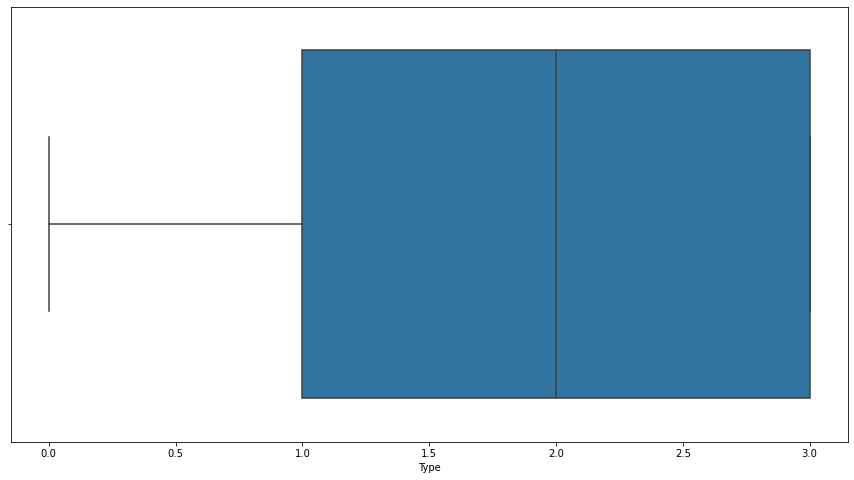


 Skewness of  Type is :  0.02195154794716029


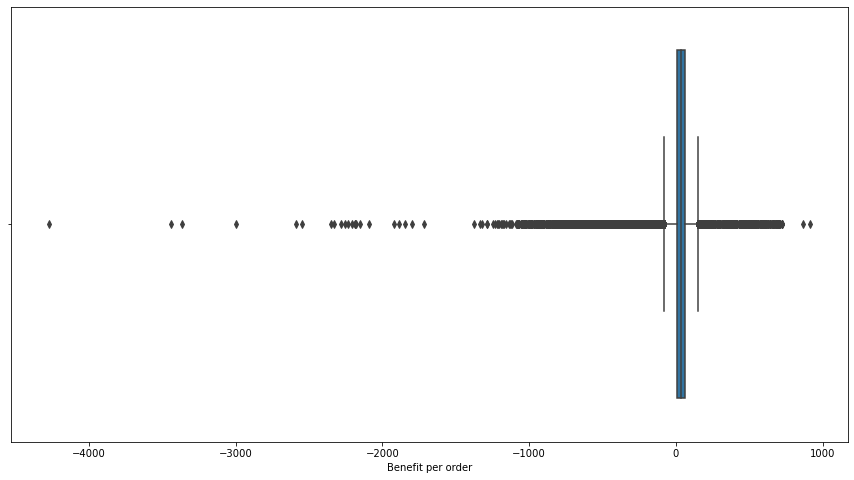


 Skewness of  Benefit per order is :  -4.741796787312843


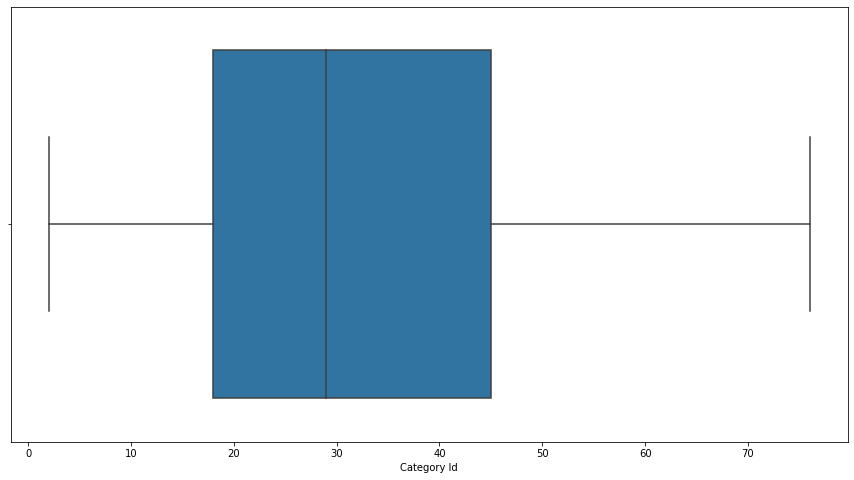


 Skewness of  Category Id is :  0.36157141139709814


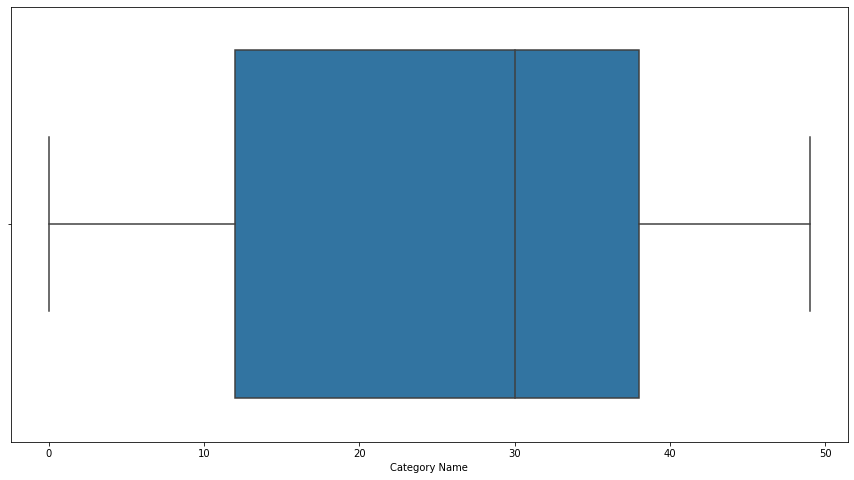


 Skewness of  Category Name is :  0.06603706711928721


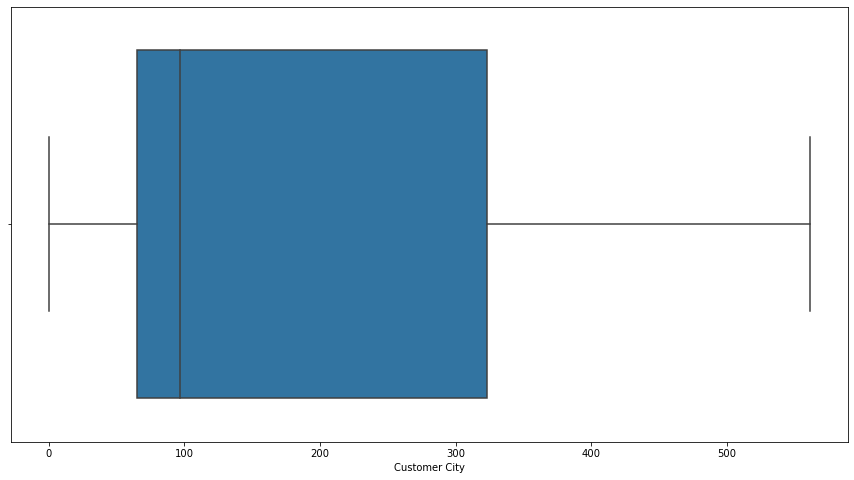


 Skewness of  Customer City is :  0.7901980927784948


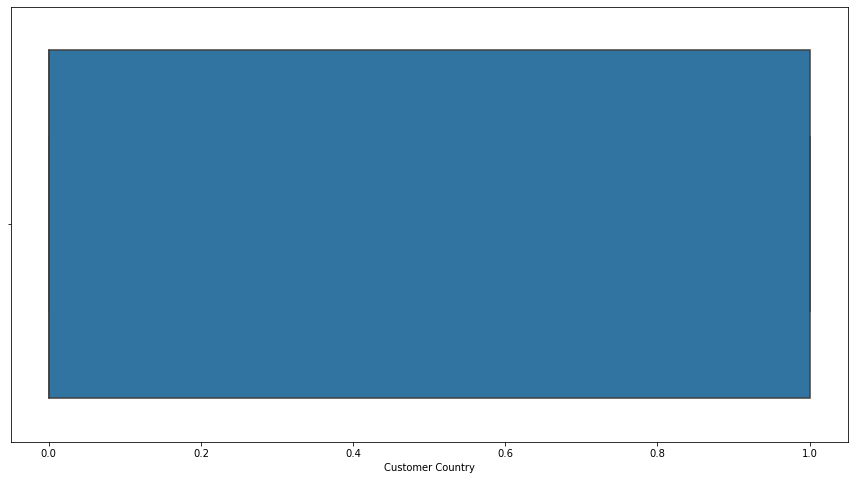


 Skewness of  Customer Country is :  0.475698507243215


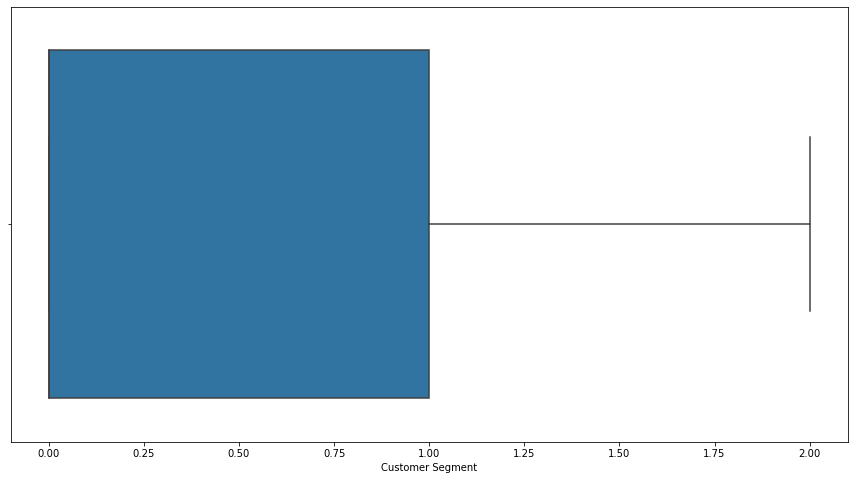


 Skewness of  Customer Segment is :  0.6579930558959575


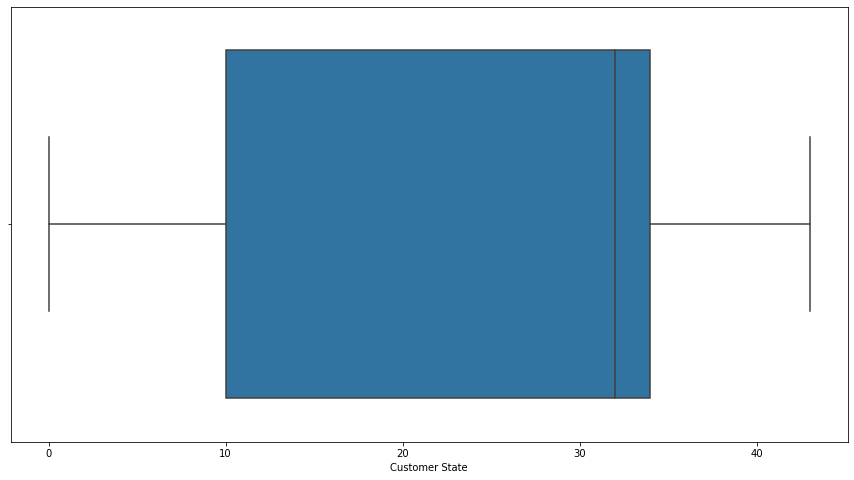


 Skewness of  Customer State is :  -0.664760520813589


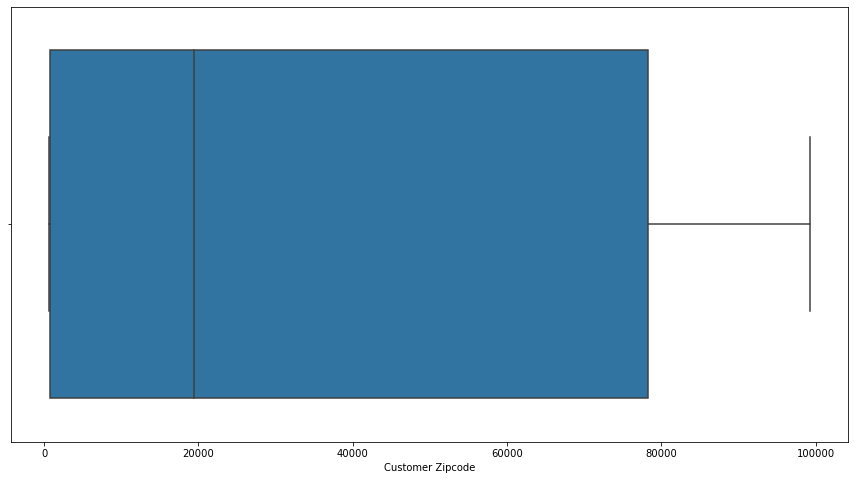


 Skewness of  Customer Zipcode is :  0.49088340953712706


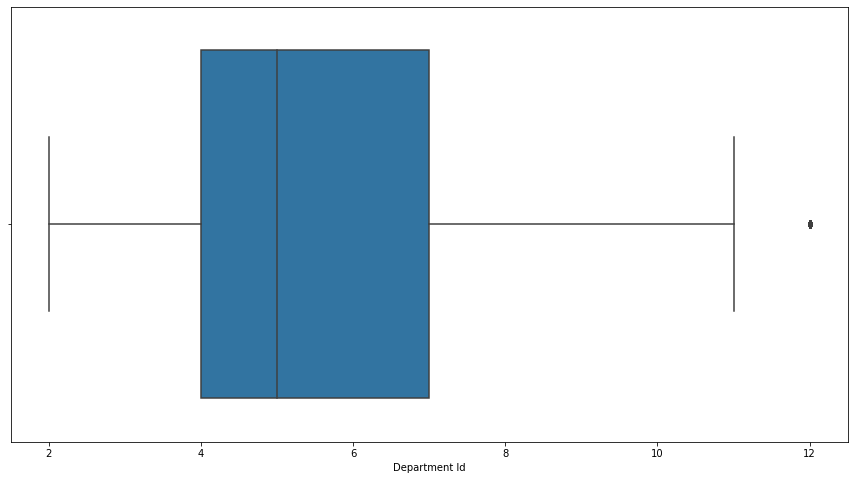


 Skewness of  Department Id is :  0.27324179597496956


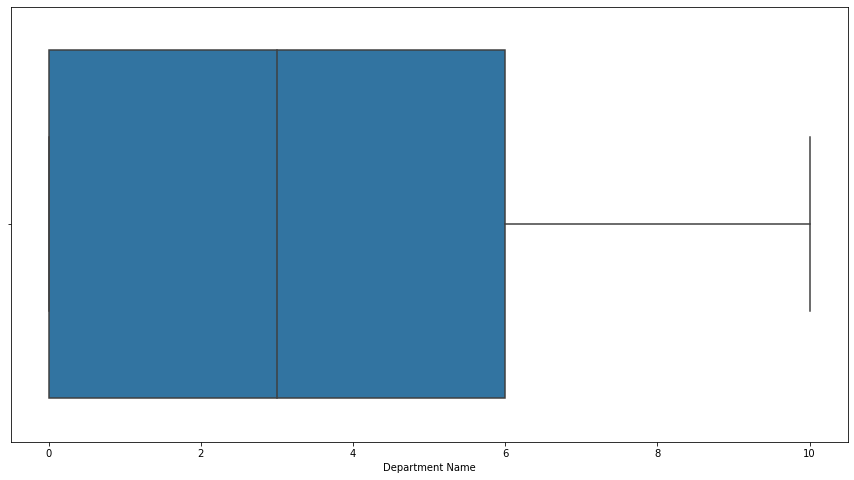


 Skewness of  Department Name is :  0.24457663830108953


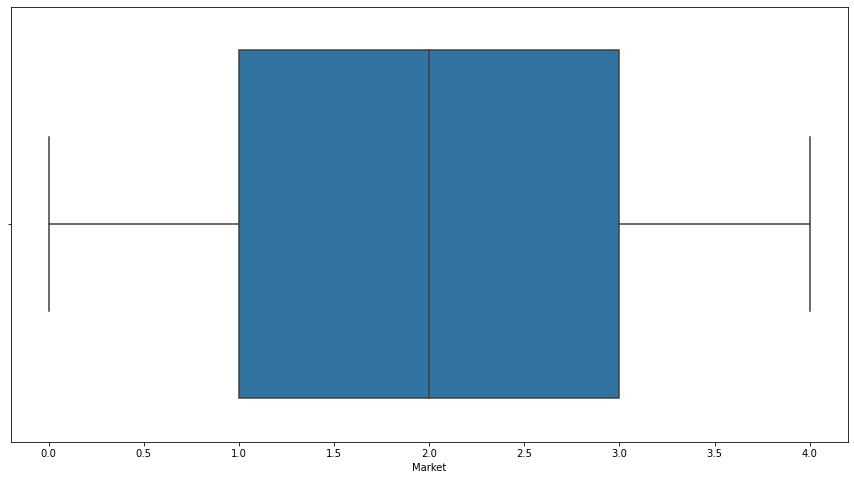


 Skewness of  Market is :  0.09910321779125612


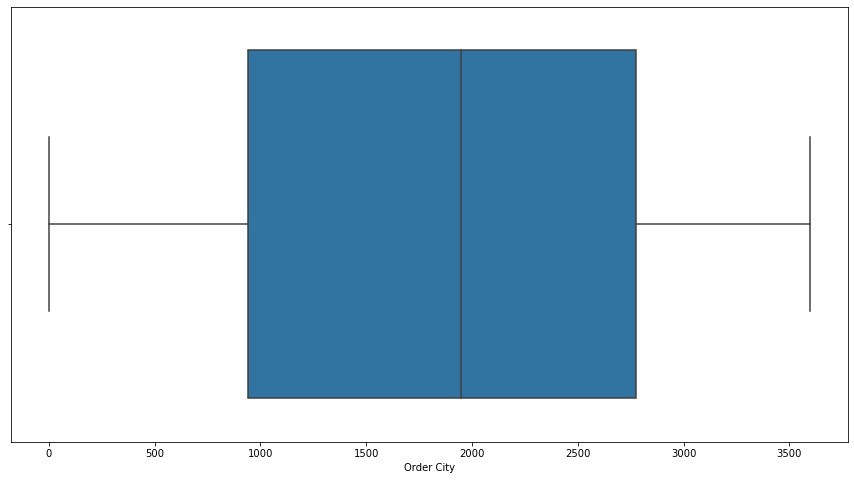


 Skewness of  Order City is :  -0.1309432023917752


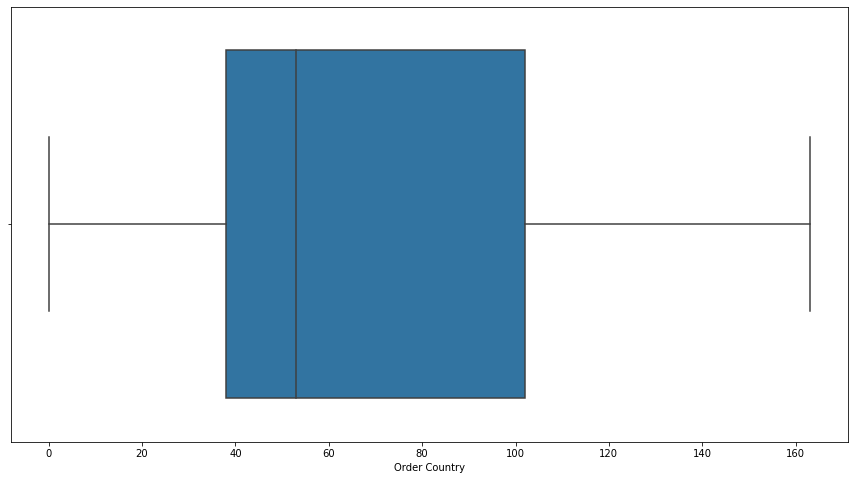


 Skewness of  Order Country is :  0.3954177143663733


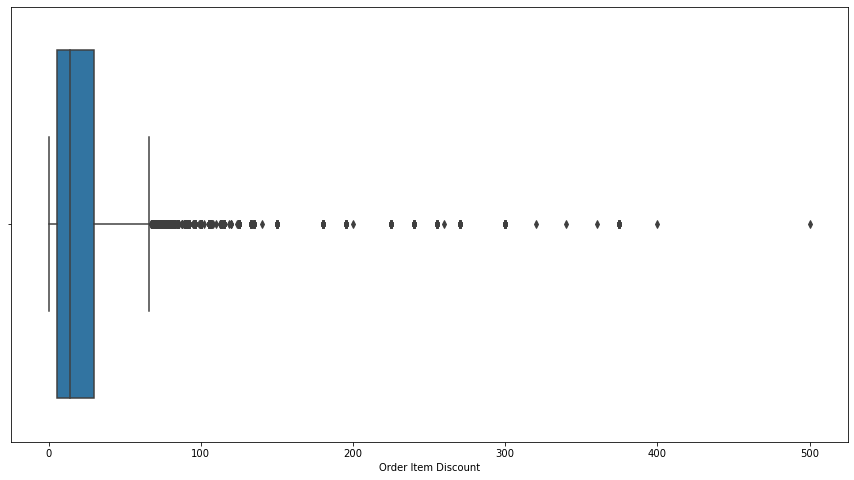


 Skewness of  Order Item Discount is :  3.0399403308380126


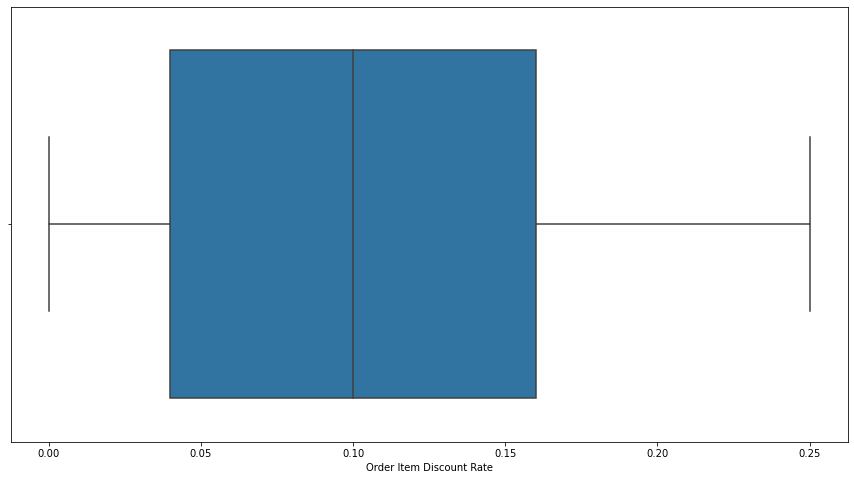


 Skewness of  Order Item Discount Rate is :  0.3409263043572849


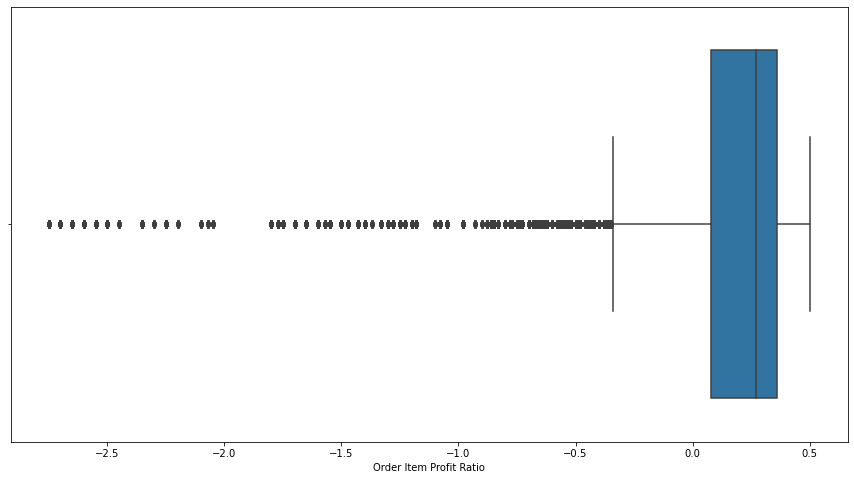


 Skewness of  Order Item Profit Ratio is :  -2.8935008398426443


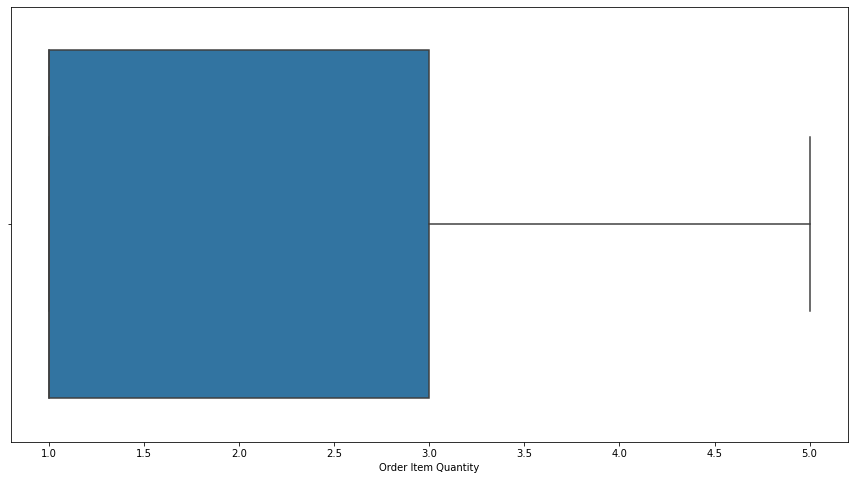


 Skewness of  Order Item Quantity is :  0.8802268217380301


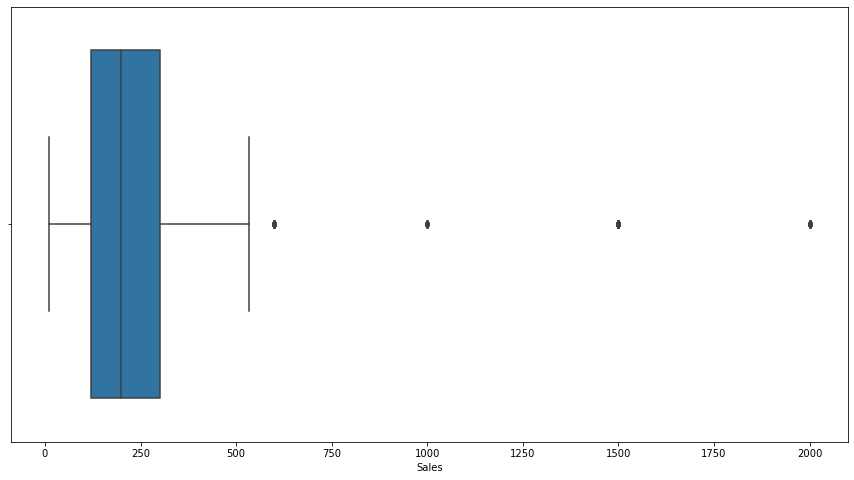


 Skewness of  Sales is :  2.884303920171953


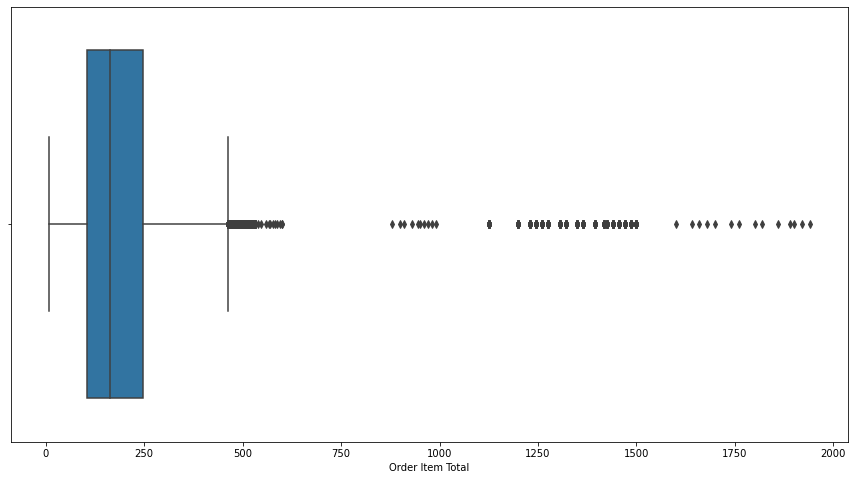


 Skewness of  Order Item Total is :  2.8884810873783624


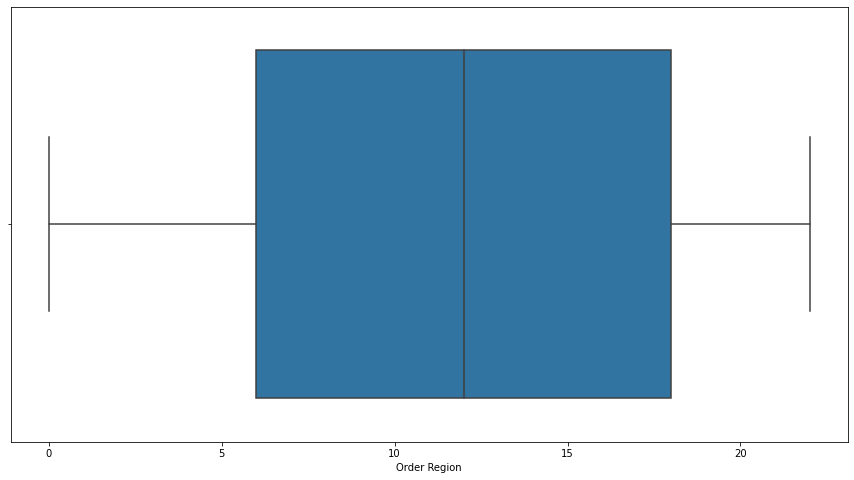


 Skewness of  Order Region is :  -0.03445873288565379


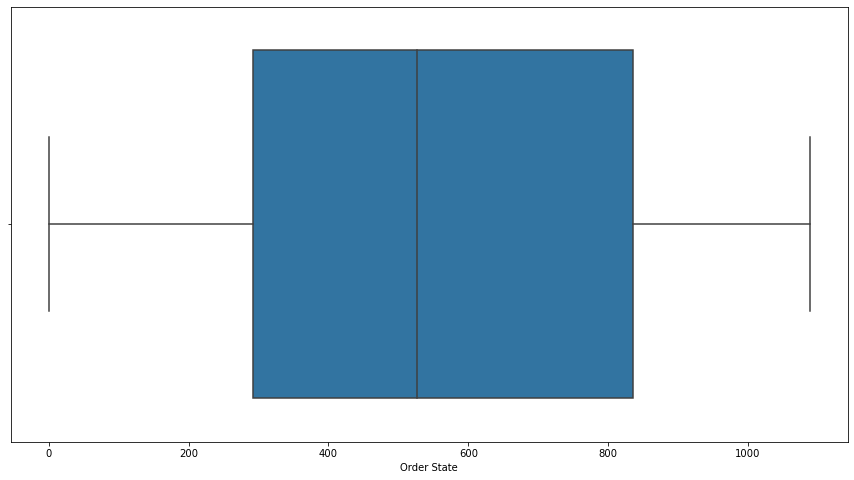


 Skewness of  Order State is :  -0.012626529400382499


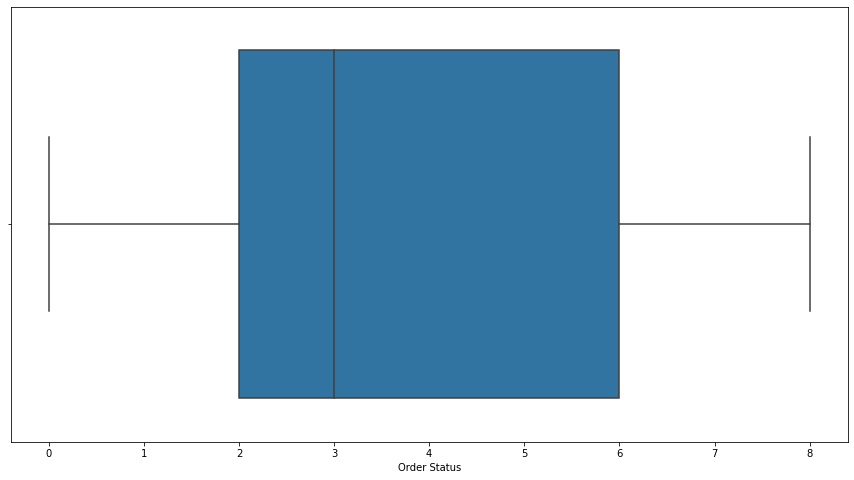


 Skewness of  Order Status is :  0.12177231957094382


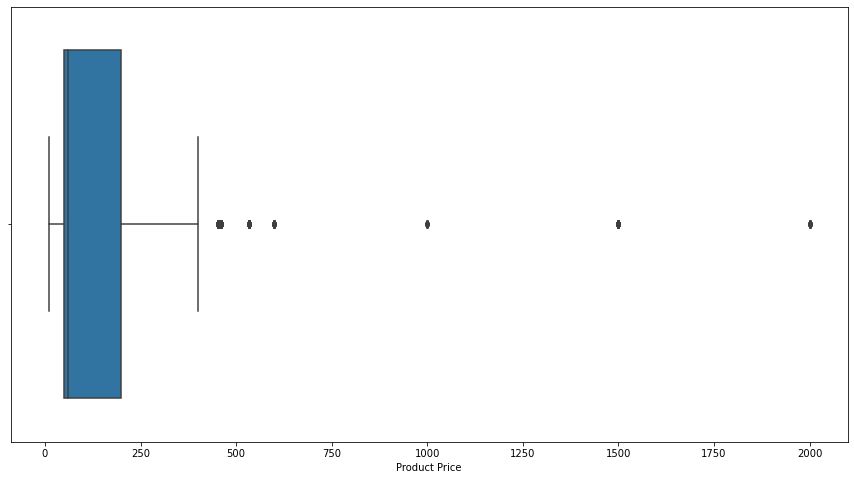


 Skewness of  Product Price is :  3.191093007406851


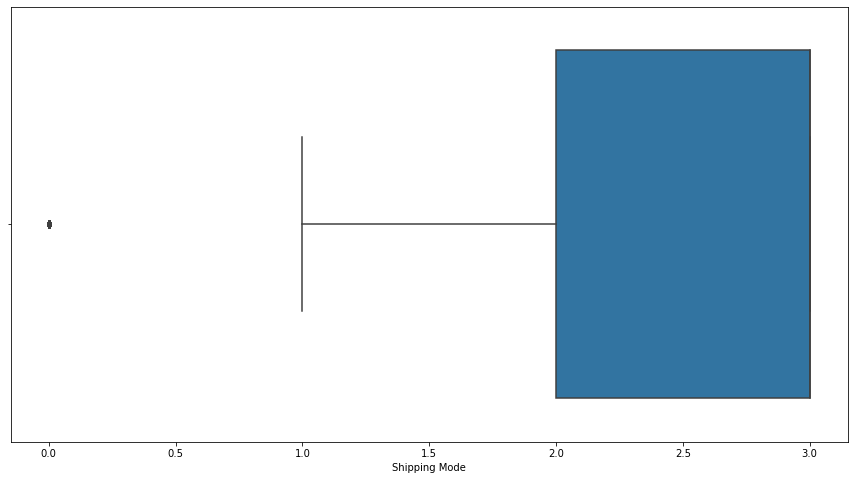


 Skewness of  Shipping Mode is :  -1.1664263180839645


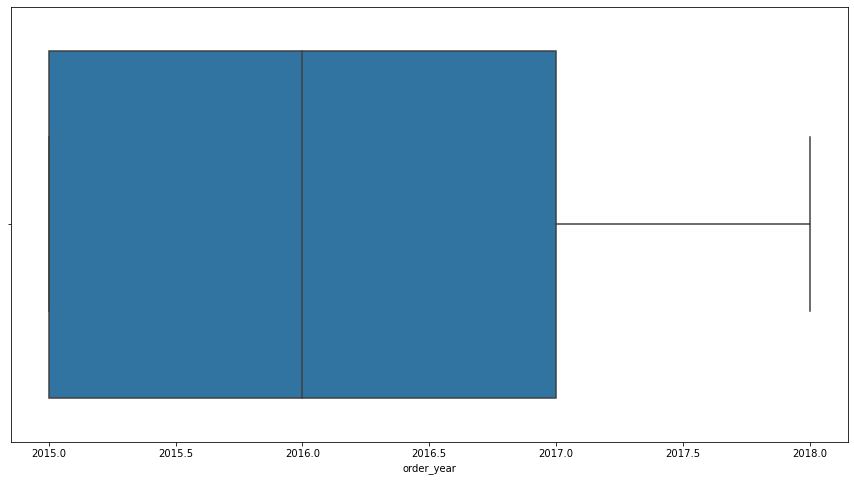


 Skewness of  order_year is :  0.1775322850663887


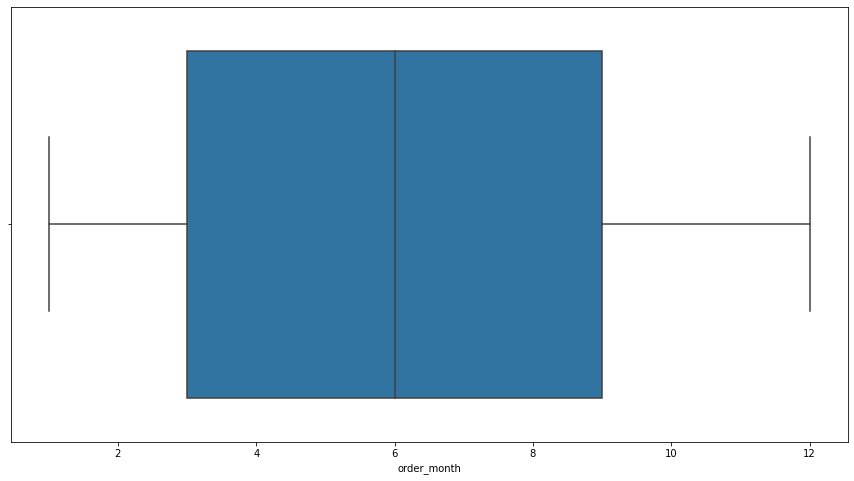


 Skewness of  order_month is :  0.04212125514809873


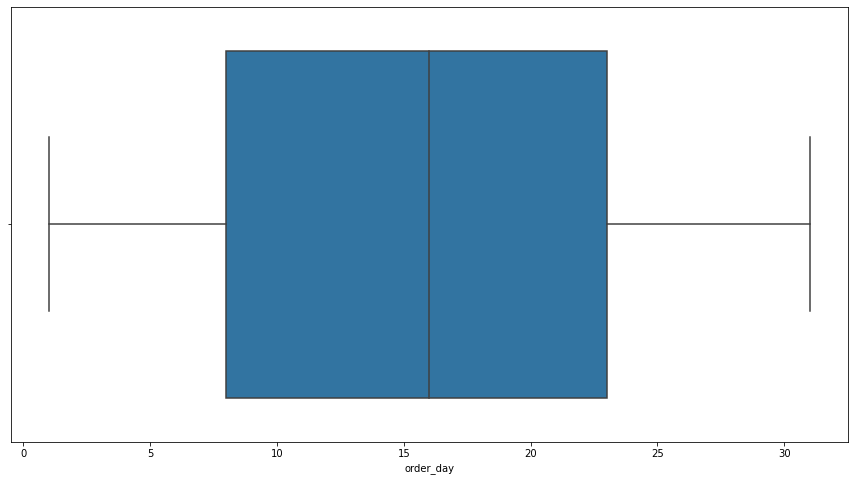


 Skewness of  order_day is :  0.002097738345393897


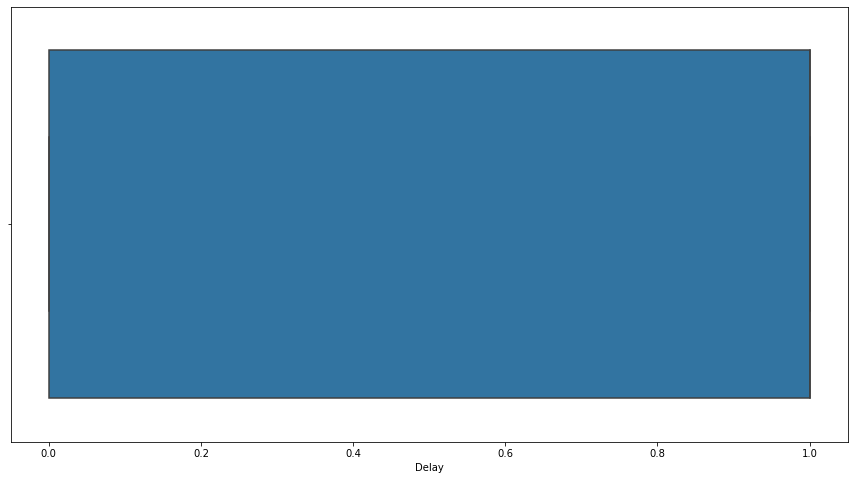


 Skewness of  Delay is :  -0.2943261077873947


In [32]:
for i in df[numeric].columns:
    sns.boxplot(df[i])
    plt.show()
    print('\n','Skewness of ',i,'is : ',df[i].skew())
    

In [33]:
for i in df.select_dtypes(include='object').columns:
    plt.xticks(rotation=90)
    sns.countplot(df[i])
    print('\n',i)
    plt.show()

In [34]:
feature_names  =  df.columns.drop('Delay')
print(feature_names)

Index(['Type', 'Benefit per order', 'Category Id', 'Category Name',
       'Customer City', 'Customer Country', 'Customer Segment',
       'Customer State', 'Customer Zipcode', 'Department Id',
       'Department Name', 'Market', 'Order City', 'Order Country',
       'Order Item Discount', 'Order Item Discount Rate',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Region', 'Order State', 'Order Status',
       'Product Price', 'Shipping Mode', 'order_year', 'order_month',
       'order_day'],
      dtype='object')


In [35]:
X              =  df.loc[:,feature_names] 
y              =  df.loc[:,'Delay']
label_names    =  y.unique()
print(X.shape)
print(y.shape)

y.value_counts().apply(lambda x: [x, ( x * 100) / df.shape[0]])

(180516, 28)
(180516,)


1    [103399, 57.27968711914733]
0     [77117, 42.72031288085267]
Name: Delay, dtype: object

### Observation

Since the two classes of the target variable are not in the proportion of 50:50, we conclude that there is slight imbalance in the dataset.

## Model Building

Recursive partitioning is a fundamental tool in data mining. It helps us explore the structure of a set of data, while developing easy to visualize decision rules for predicting a categorical (classification tree) or continuous (regression tree) outcome.

CART Modeling via DecisionTreeClassifier

Classification and Regression Trees (as described by Brieman, Freidman, Olshenm and Stone) can be generated through the DecisionTreeClassifier package.

i) Grow the tree

For controlling tree growth, we set the following parameters:
* max_depth: The maximum depth of the tree.
* min_samples_split: The minimum number of samples required to split an internal node
* min_samples_leaf: min no of samples at a leaf node
* min_impurity_decrease : A node will be split if this split induces a decrease of the impurity greater than or equal to this value. 

### 2.7 Train Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 10, test_size = 0.2)

print('X_train', X_train.shape)
print('y_train', y_train.shape)

print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (144412, 28)
y_train (144412,)
X_test (36104, 28)
y_test (36104,)


#### Create a generalized function to calculate the metrics for the train and the test set.

In [37]:
decision_tree_classification = DecisionTreeClassifier(criterion = 'entropy', random_state = 10)

decision_tree = decision_tree_classification.fit(X_train, y_train)


Training Data
[[61879     0]
 [    0 82533]]


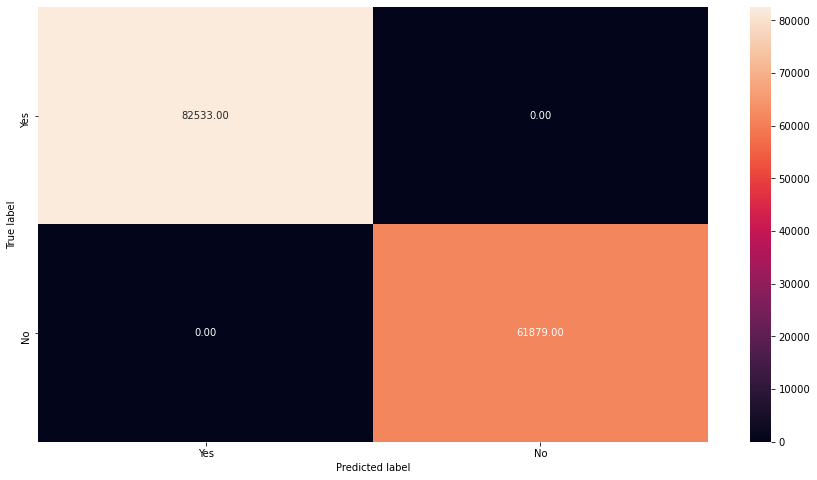

Training Accuracy: 100.000%


In [38]:
#Predict the response for train dataset
predicted_train    = decision_tree.predict(X_train)
matrix             = confusion_matrix(y_train, predicted_train)
print("\nTraining Data")
print(matrix)
draw_cm(y_train, predicted_train )
    
accuracy_train = decision_tree.score(X_train, y_train) 
print("Training Accuracy: %.3f%%" % (accuracy_train * 100.0))


Training data


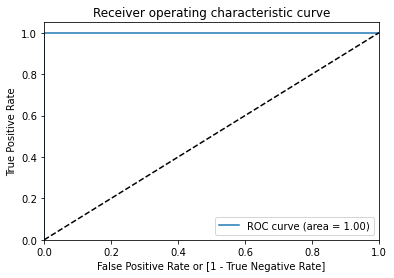

(array([0., 0., 1.]), array([0., 1., 1.]), array([2, 1, 0]))

In [39]:
print("\nTraining data")
draw_roc( y_train, predicted_train)  

In [40]:
#Predict the response for test dataset
predicted_testing = decision_tree.predict(X_test)


Testing Data
[[12401  2837]
 [ 2826 18040]]


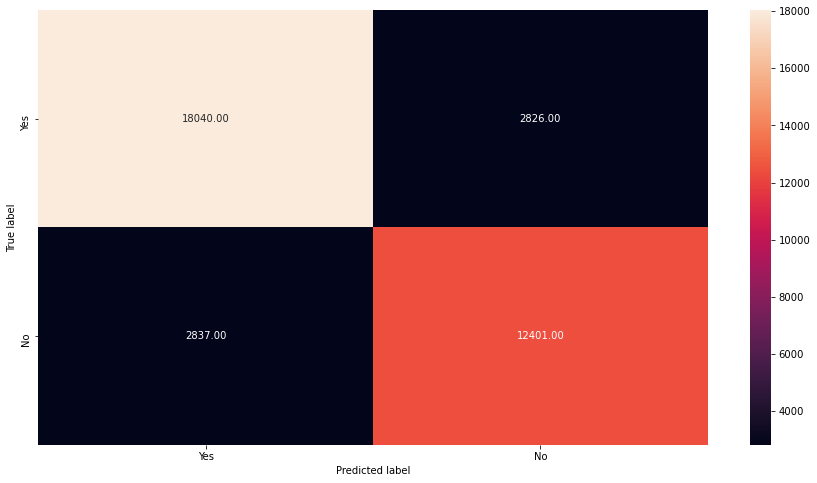

Testing Accuracy: 84.315%


In [41]:
matrix             = confusion_matrix(y_test, predicted_testing)
print("\nTesting Data")
print(matrix)
draw_cm(y_test, predicted_testing )
    
accuracy_train = decision_tree.score(X_test, y_test) 
print("Testing Accuracy: %.3f%%" % (accuracy_train * 100.0))


Testing  data


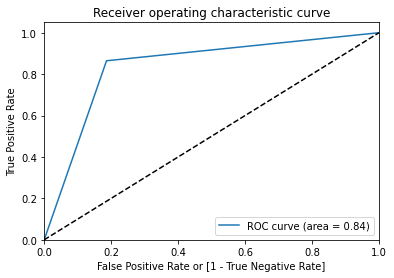

(array([0.        , 0.18617929, 1.        ]),
 array([0.        , 0.86456436, 1.        ]),
 array([2, 1, 0]))

In [42]:
print("\nTesting  data")
draw_roc( y_test, predicted_testing)  

In [43]:
train_report = get_train_report(decision_tree)

print(train_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61879
           1       1.00      1.00      1.00     82533

    accuracy                           1.00    144412
   macro avg       1.00      1.00      1.00    144412
weighted avg       1.00      1.00      1.00    144412



In [44]:
test_report = get_test_report(decision_tree)

print(test_report)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81     15238
           1       0.86      0.86      0.86     20866

    accuracy                           0.84     36104
   macro avg       0.84      0.84      0.84     36104
weighted avg       0.84      0.84      0.84     36104



In [45]:
# feature_names 
class_names   =  ['No Delay','Delay']

### Plot variable importance plot

Text(0.5, 0, 'Decision Tree Feature Importance')

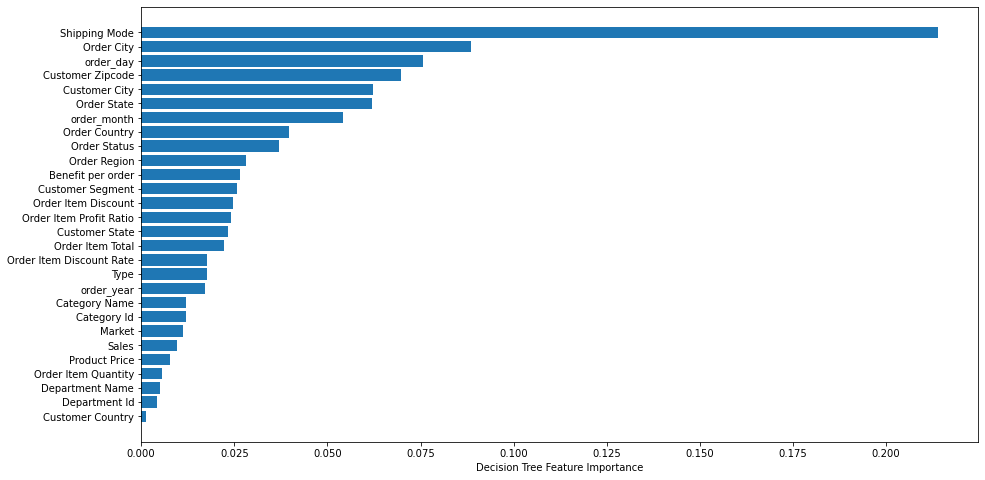

In [46]:
sorted_idx = decision_tree.feature_importances_.argsort()
plt.barh(feature_names[sorted_idx], decision_tree.feature_importances_[sorted_idx])
plt.xlabel("Decision Tree Feature Importance")

### Observation

Top six variables influencing the target variable, Delay
1.  Shipping Mode
2.  Order City
3.  Order Day
4.  Customer ZIP code, Customer City
5.  Order Status
6.  Order Region